# Face Recognition


Using Triplet loss function to learn the parameters of the Siamese
Neural Network and generating encoding of the images such that
same person have same encoding (a one shot learning algorithm)

#### Load packages
Let's load the required packages. 

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## Naive Face Verification Technique

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person! 

# One Shot Learning Technique


### Encoding face images using a ConvNet 

In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280




### Function Used - The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$



In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
   
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
   
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
   
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha) 
    
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
   
    return loss

In [5]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.143


## Loading the pre-trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## Applying the model

###  Face Verification


In [7]:
database = {}
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)
database["shahla"] = img_to_encoding("images/sha4.jpeg", FRmodel)


In [8]:
def verify(image_path, identity, database, model):
    
    # Step 1: Compute the encoding for the image
    encoding = img_to_encoding(image_path=image_path ,model=model)
    
    # Step 2: Compute distance with identity's image 
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open 
    if dist<0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    
    return dist, door_open

### Face Verification Application

It's shahla, welcome in!


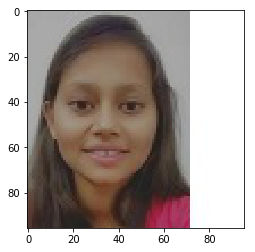

In [9]:
path ="images/sha2.jpeg"
verify(path, "shahla", database, FRmodel)
from matplotlib.pyplot import imshow
import scipy.misc
content_image = scipy.misc.imread(path)
imshow(content_image);

**Succesfully Face Detected**